# Geant4 Validation of Photo-nuclear Fixes
## Omar Moreno, SLAC National Accelerator Laboratory
---
---

In [16]:
from __future__ import division

# This allows matplotlib plots to be shown inline
%matplotlib inline

import collections
import math
import numpy as np
import ROOT as r
import root_numpy as rnp

from rootpy.plotting import Hist, Hist2D, Graph

# This allows matplotlib plots to be shown inline
%matplotlib inline

import collections
import math
import numpy as np
import ROOT as r
import root_numpy as rnp

import matplotlib.pyplot as plt
import matplotlib

from matplotlib.colors import LogNorm

plt.style.use('fivethirtyeight')
plt.rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size' : 35})

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

r.gStyle.SetOptStat(0)
r.gErrorIgnoreLevel = r.kWarning
r.gStyle.SetGridColor(17)
r.gStyle.SetCanvasDefW(900)
r.gStyle.SetCanvasDefH(500)
r.gStyle.SetCanvasColor(0)
r.gStyle.SetCanvasBorderMode(0)
r.gStyle.SetCanvasBorderSize(0)
r.gStyle.SetPadBottomMargin(0.1)
r.gStyle.SetPadTopMargin(0.01)
r.gStyle.SetPadLeftMargin(0.1)
r.gStyle.SetPadRightMargin(0.09)
r.gStyle.SetPadGridX(1)
r.gStyle.SetPadGridY(1)
r.gStyle.SetPadTickX(1)
r.gStyle.SetPadTickY(1)
r.gStyle.SetFrameBorderMode(0)
r.gStyle.SetTitleOffset(1.2, "yx")
r.gStyle.SetOptLogy(1)
r.gStyle.SetTitleFontSize(25)

canvas = r.TCanvas()

In [17]:
file_names = collections.OrderedDict([
    ('ECal PN - G4 Fix', 'ecal_pn_v5_pi_neutron_20180626_validation_analysis.root'),
    ('ECal PN - Nominal', 'ecal_pn_v5_20180327_inclusive_analysis.root'), 
    ('ECal PN - G4 Fix, Pre-Trig', 'ecal_pn_v5_pi_neutron_20180625_validation_analysis_pre_trig.root'), 
    ('ECal PN - G4 Fix, Pre-Trig, Potential Thickenss = 0', 'ecal_pn_v5_pi_neutron_20180626_validation_analysis_pt0.root')
])

tracker_ntuples = collections.OrderedDict()
pn_ntuples      = collections.OrderedDict()
hcal_ntuples    = collections.OrderedDict()
ecal_ntuples    = collections.OrderedDict()
trigger_ntuples = collections.OrderedDict()
event_ntuples   = collections.OrderedDict()
for key, value in file_names.iteritems(): 
    tracker_ntuples[key] = rnp.root2array(value, 'tracker_ntuple')
    hcal_ntuples[key]    = rnp.root2array(value, 'hcal_ntuple')
    ecal_ntuples[key]    = rnp.root2array(value, 'ecal_ntuple')
    trigger_ntuples[key] = rnp.root2array(value, 'trigger_ntuple')
    pn_ntuples[key]      = rnp.root2array(value, 'pn_ntuple') 
    
hcal_ntuples['Ecal PN - Nominal'] = rnp.root2array('ecal_pn_v5_20180327_inclusive_analysis_v5_hcal.root', 'hcal_ntuple')
    
hcal_max_pe  = collections.OrderedDict()
bdt_cut      = collections.OrderedDict()
for key, value in ecal_ntuples.iteritems():
    bdt_cut[key] = (ecal_ntuples[key]['passes_ecal_veto'] == 1)
    
for key, value in hcal_ntuples.iteritems():
    hcal_max_pe[key] = (hcal_ntuples[key]['max_pe'] < 3)


In [18]:
# Plotting functions
def overlay_plot(ax, ntuples, variable, bins, cuts):
    
    for key, value in ntuples.iteritems():
        cut = np.ones(len(ntuples[key][variable]), dtype=bool)
        for c in cuts: 
            cut = cut & c[key]
            
        ax.hist(ntuples[key][variable][cut], bins=bins, histtype='step', linewidth=2, normed=True, label=key)
        
def overlay_plot_1d(ntuples, variable, bins, min_x, max_x, cuts):
    #leg = r.TLegend(0.6, 0.7, 0.89, 0.89)

    hists = collections.OrderedDict()
    index = 0
    for key, value in file_names.iteritems(): 
        hists[key] = Hist(bins, min_x, max_x)
        cut = np.ones(len(ntuples[key][variable]), dtype=bool)
        for c in cuts: 
            if key in c: cut = cut & c[key]
        
        _ = rnp.fill_hist(hists[key], ntuples[key][variable][cut])
        hists[key].Scale(1/hists[key].Integral())
        
        hists[key].GetXaxis().CenterTitle()
        hists[key].color = colors[index]
        hists[key].linewidth = 2
        hists[key].GetXaxis().SetAxisColor(16)
        hists[key].GetYaxis().SetAxisColor(16)
        index += 1

    return hists

def draw_hist2D(x_variable, y_variable, bins_x, min_x, max_x, bins_y, min_y, max_y, cuts): 
    
    hist = Hist2D(bins_x, min_x, max_x, bins_y, min_y, max_y)
    cut = np.ones(len(x_variable), dtype=bool)
    for c in cuts: 
        if key in c: cut = cut & c[key]
    
    a = np.column_stack((x_variable[cut], y_variable[cut]))
    
    _ = rnp.fill_hist(hist, a)
    hist.GetXaxis().CenterTitle()
    hist.GetYaxis().CenterTitle()
    
    return hist
    

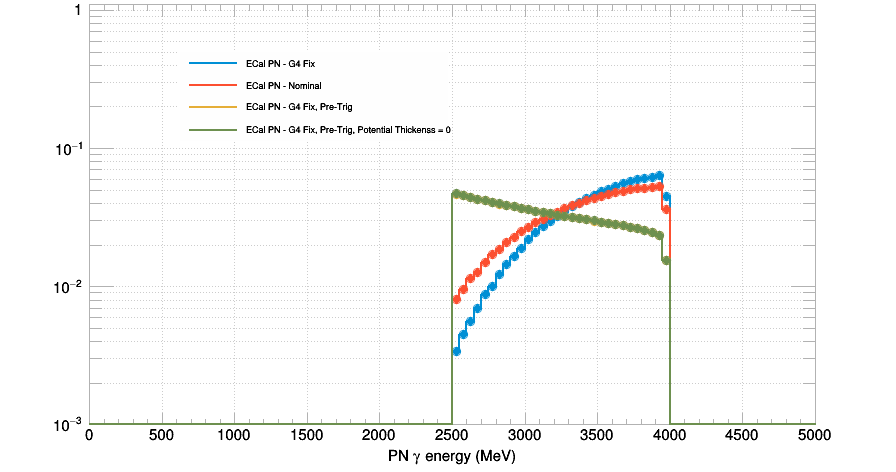

In [19]:
hists = overlay_plot_1d(pn_ntuples, 'pn_gamma_energy', 100, 0, 5000, [])

leg = r.TLegend(0.2, 0.7, 0.5, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("PN #gamma energy (MeV)")
    leg.AddEntry(hists[key], key, 'l')
    hists[key].GetYaxis().SetRangeUser(1e-3, 1.1)
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

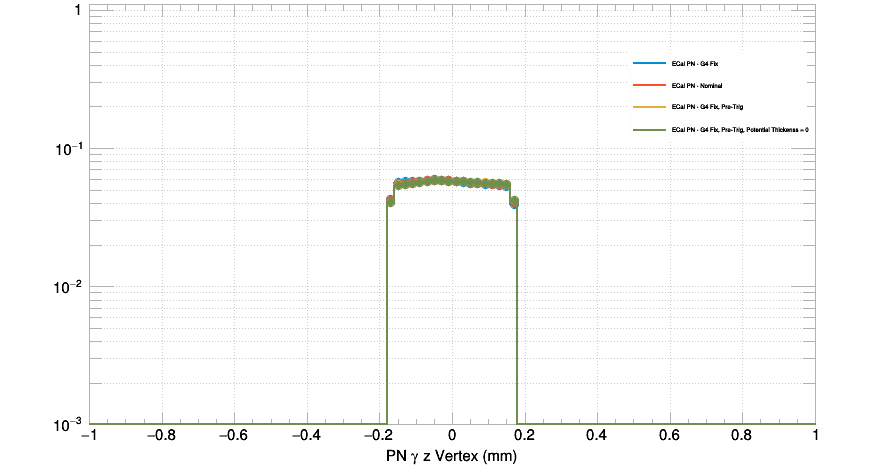

In [20]:
hists = overlay_plot_1d(pn_ntuples, 'pn_gamma_vertex_z', 100, -1, 1, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("PN #gamma z Vertex (mm)")
    leg.AddEntry(hists[key], key, 'l')
    hists[key].GetYaxis().SetRangeUser(1e-3, 1.1)
    
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.Draw()

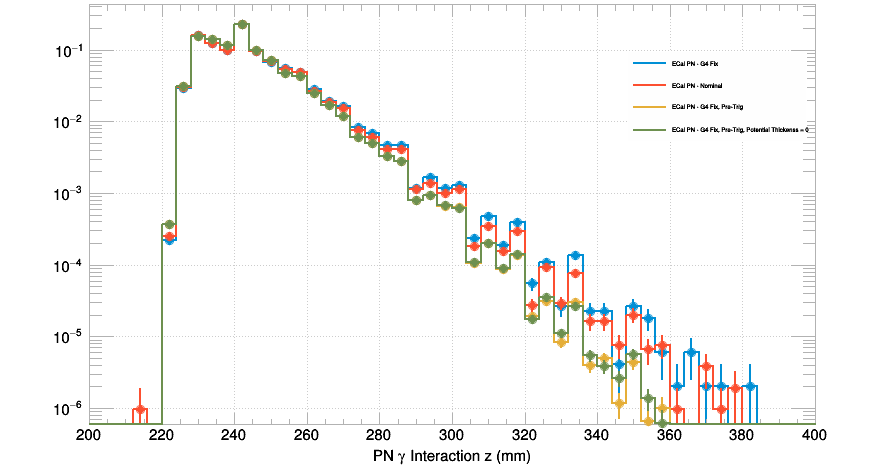

In [21]:
hists = overlay_plot_1d(pn_ntuples, 'pn_gamma_int_z', 50, 200, 400, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("PN #gamma Interaction z (mm)")
    leg.AddEntry(hists[key], key, 'l')
    #hists[key].GetYaxis().SetRangeUser(1e-4, 1.1)
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.Draw()

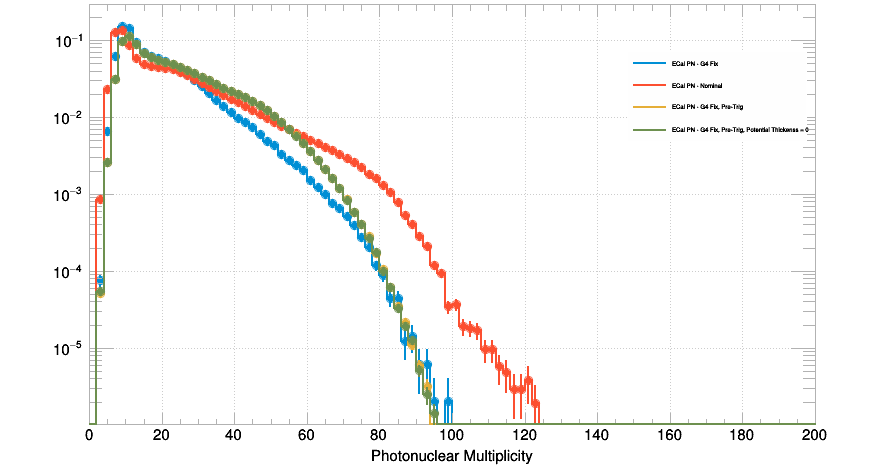

In [22]:
hists = overlay_plot_1d(pn_ntuples, 'pn_particle_mult', 100, 0, 200, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("Photonuclear Multiplicity")
    leg.AddEntry(hists[key], key, 'l')
    #hists[key].GetYaxis().SetRangeUser(1e-3, 1.1)
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.Draw()

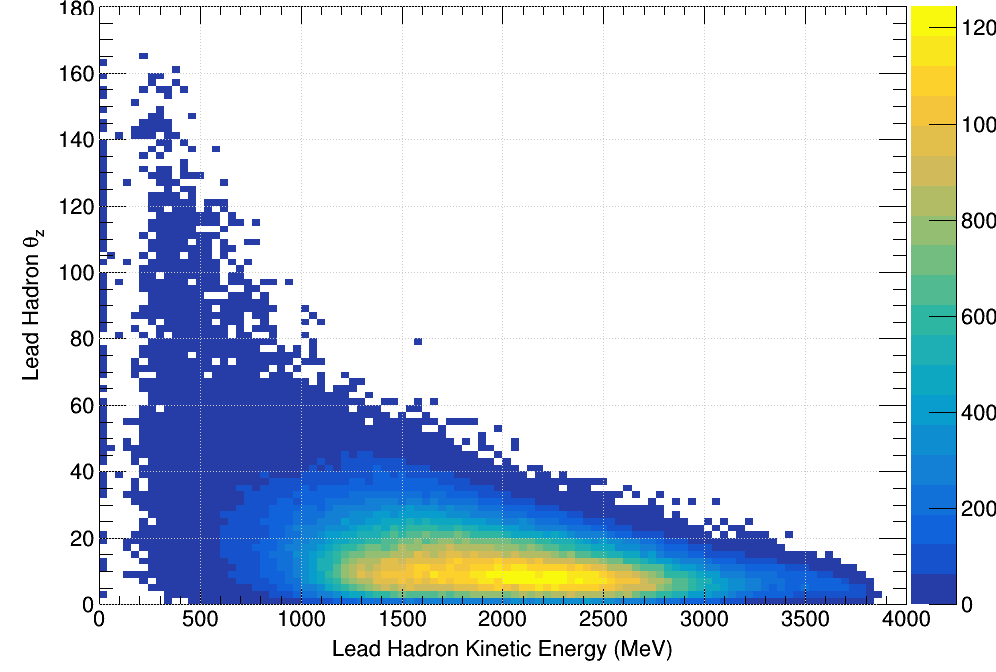

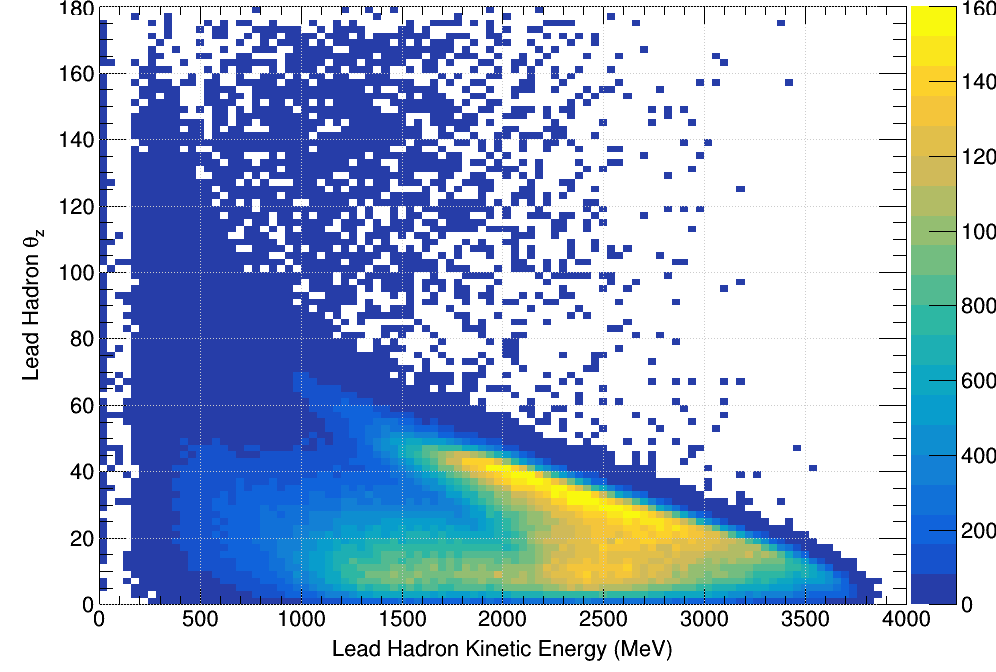

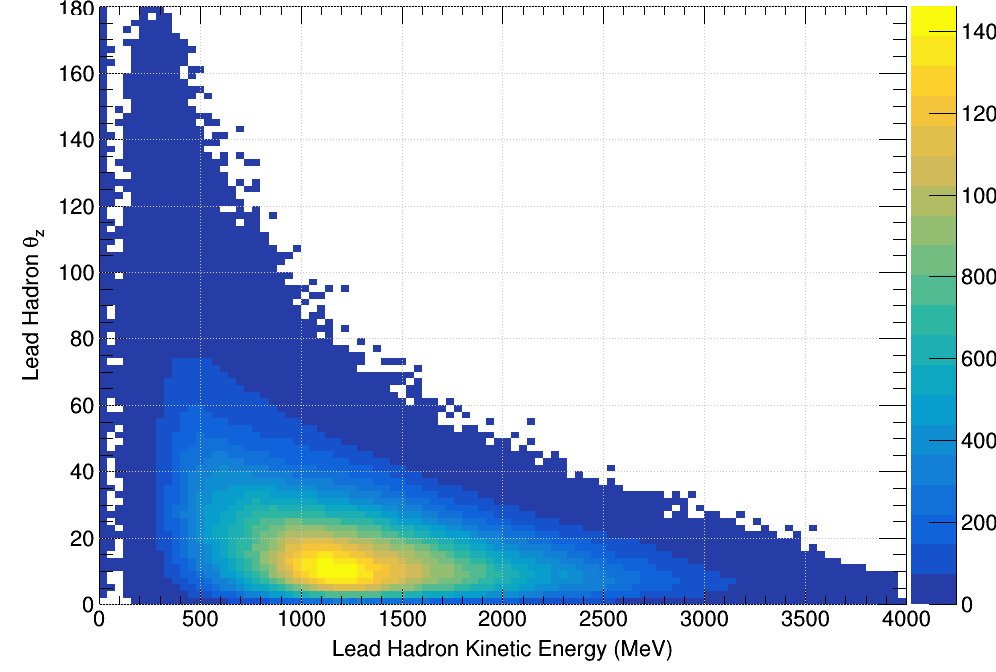

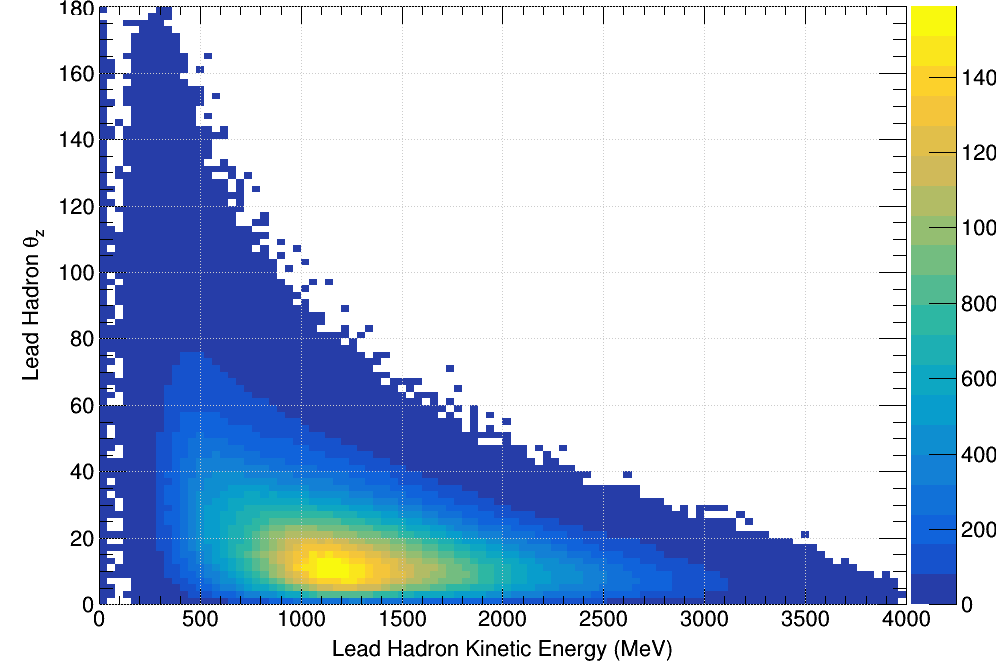

In [25]:
canvas = r.TCanvas('canvas', 'canvas', 1000, 700)
r.gStyle.SetOptStat(0)

key = "ECal PN - G4 Fix"

hist = r.TH2F('hist', 'hist', 100, 0, 4000, 90, 0, 180)
a = np.column_stack((
    pn_ntuples[key]['lead_hadron_ke'], 
    pn_ntuples[key]['lead_hadron_theta_z'],
                    ))
_ = rnp.fill_hist(hist, a)

hist.Draw("colz")
hist.GetXaxis().SetTitle('Lead Hadron Kinetic Energy (MeV)')
hist.GetXaxis().CenterTitle()
hist.GetYaxis().SetTitle('Lead Hadron #theta_{z}')
hist.GetYaxis().CenterTitle()

canvas.SetLogy(0)
canvas.SetLogz(0)
canvas.Draw()
canvas.SaveAs("energy_angle_regen.pdf")

key = "ECal PN - Nominal"

hist = r.TH2F('hist', 'hist', 100, 0, 4000, 90, 0, 180)
a = np.column_stack((
    pn_ntuples[key]['lead_hadron_ke'], 
    pn_ntuples[key]['lead_hadron_theta_z'],
                    ))
_ = rnp.fill_hist(hist, a)

hist.Draw("colz")
hist.GetXaxis().SetTitle('Lead Hadron Kinetic Energy (MeV)')
hist.GetXaxis().CenterTitle()
hist.GetYaxis().SetTitle('Lead Hadron #theta_{z}')
hist.GetYaxis().CenterTitle()

canvas.SetLogy(0)
canvas.SetLogz(0)
canvas.Draw()
canvas.SaveAs("energy_angle_nominal.pdf")

key = "ECal PN - G4 Fix, Pre-Trig"

hist = r.TH2F('hist', 'hist', 100, 0, 4000, 90, 0, 180)
a = np.column_stack((
    pn_ntuples[key]['lead_hadron_ke'], 
    pn_ntuples[key]['lead_hadron_theta_z'],
                    ))
_ = rnp.fill_hist(hist, a)

hist.Draw("colz")
hist.GetXaxis().SetTitle('Lead Hadron Kinetic Energy (MeV)')
hist.GetXaxis().CenterTitle()
hist.GetYaxis().SetTitle('Lead Hadron #theta_{z}')
hist.GetYaxis().CenterTitle()

canvas.SetLogy(0)
canvas.SetLogz(0)
canvas.Draw()

key = "ECal PN - G4 Fix, Pre-Trig, Potential Thickenss = 0"

hist = r.TH2F('hist', 'hist', 100, 0, 4000, 90, 0, 180)
a = np.column_stack((
    pn_ntuples[key]['lead_hadron_ke'], 
    pn_ntuples[key]['lead_hadron_theta_z'],
                    ))
_ = rnp.fill_hist(hist, a)

hist.Draw("colz")
hist.GetXaxis().SetTitle('Lead Hadron Kinetic Energy (MeV)')
hist.GetXaxis().CenterTitle()
hist.GetYaxis().SetTitle('Lead Hadron #theta_{z}')
hist.GetYaxis().CenterTitle()

canvas.SetLogy(0)
canvas.SetLogz(0)
canvas.Draw()



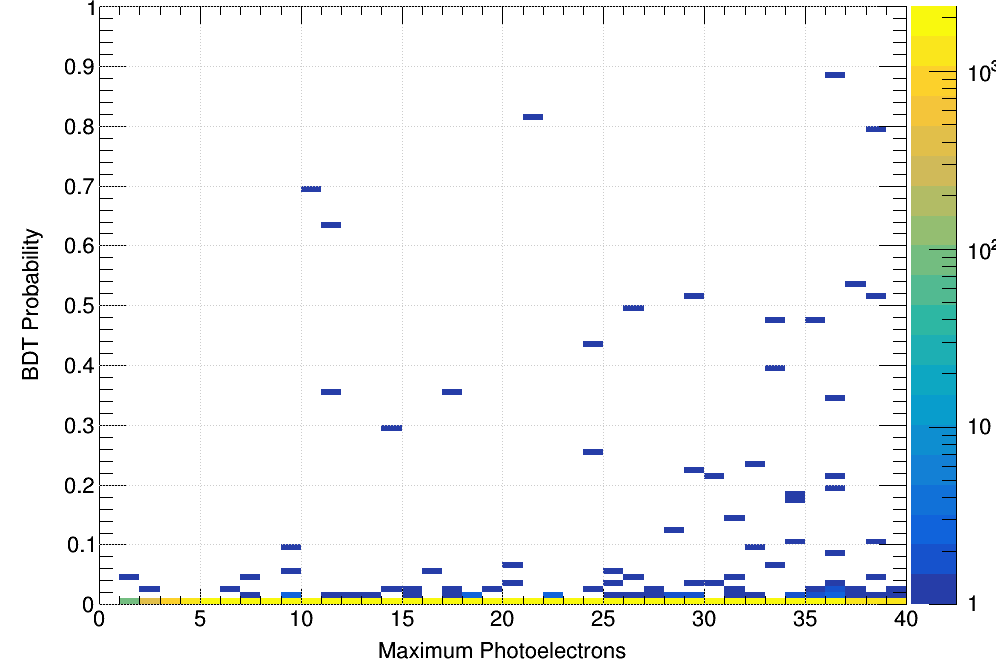

In [27]:
key = "ECal PN - G4 Fix"
hist = draw_hist2D(hcal_ntuples[key]['max_pe'], ecal_ntuples[key]['bdt_prob'], 40, 0, 40, 100, 0, 1, []) 

hist.Draw("colz")
hist.GetXaxis().SetTitle('Maximum Photoelectrons')
hist.GetYaxis().SetTitle('BDT Probability')

canvas.SetLogy(0)
canvas.SetLogz(1)
canvas.Draw()

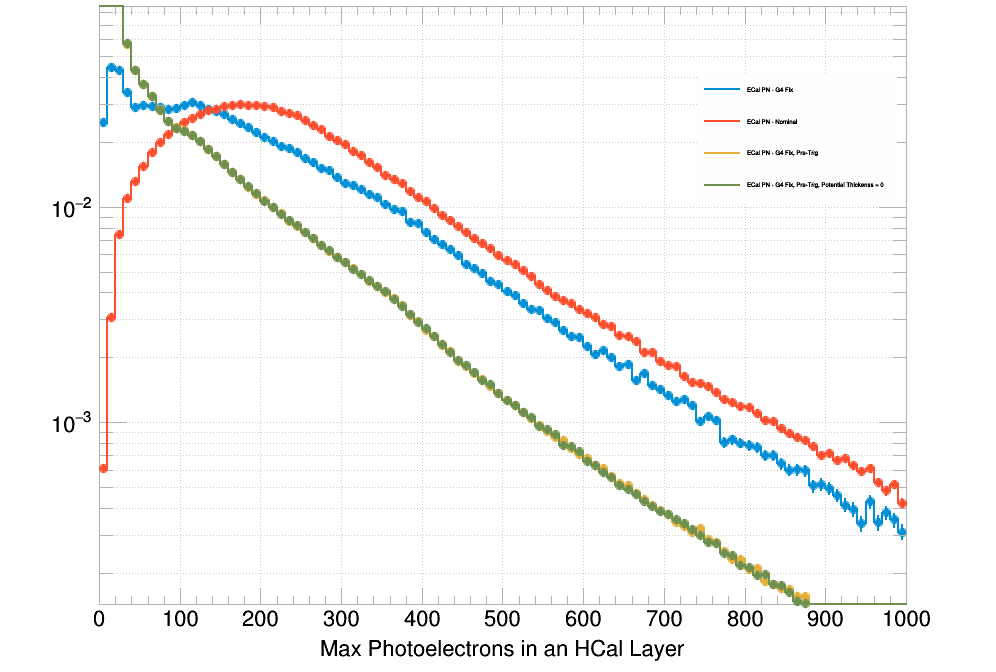

In [28]:
hists = overlay_plot_1d(hcal_ntuples, 'max_pe', 100, 0, 1000, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("Max Photoelectrons in an HCal Layer")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()
canvas.SaveAs("hcal_max_pe.pdf")

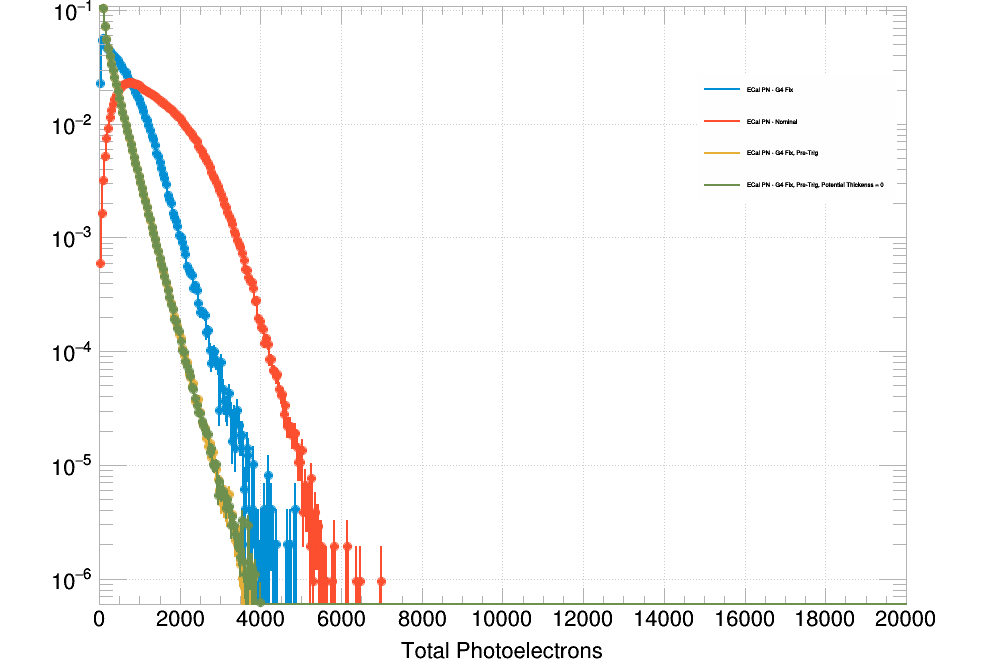

In [29]:
hists = overlay_plot_1d(hcal_ntuples, 'total_pe', 500, 0, 20000, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("Total Photoelectrons")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

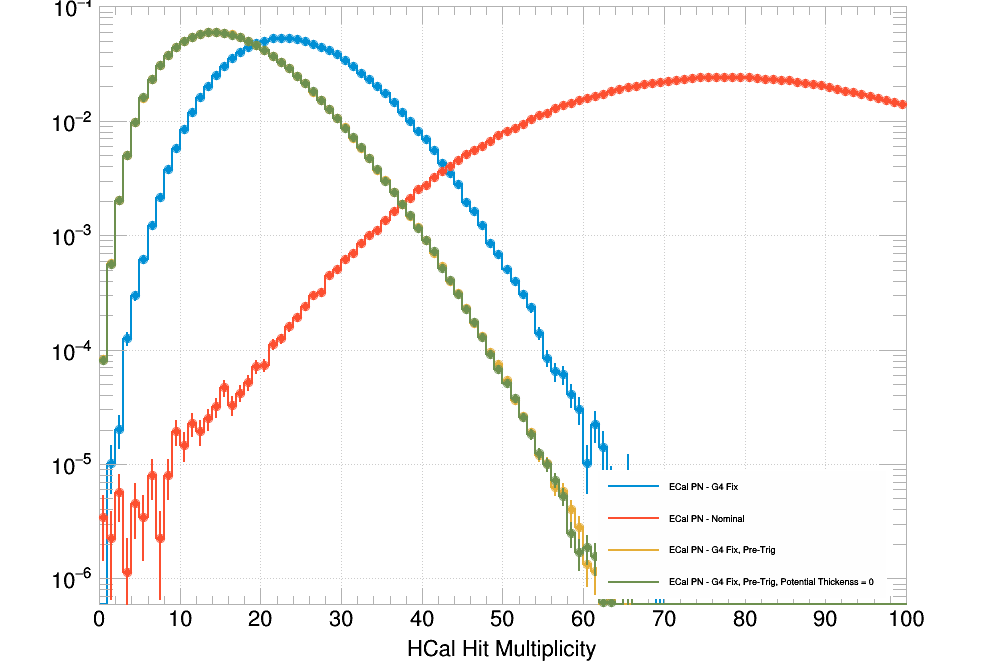

In [30]:
hists = overlay_plot_1d(hcal_ntuples, 'total_hits', 100, 0, 100, [])

leg = r.TLegend(0.6, 0.11, 0.89, 0.3)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("HCal Hit Multiplicity")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

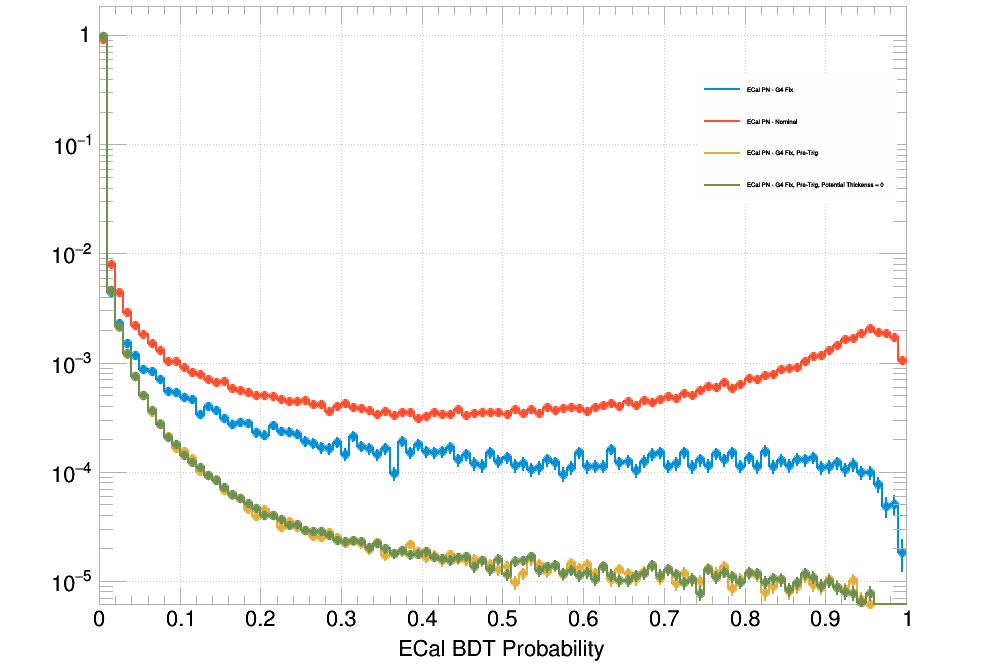

In [32]:
hists = overlay_plot_1d(ecal_ntuples, 'bdt_prob', 100, 0, 1, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("ECal BDT Probability")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

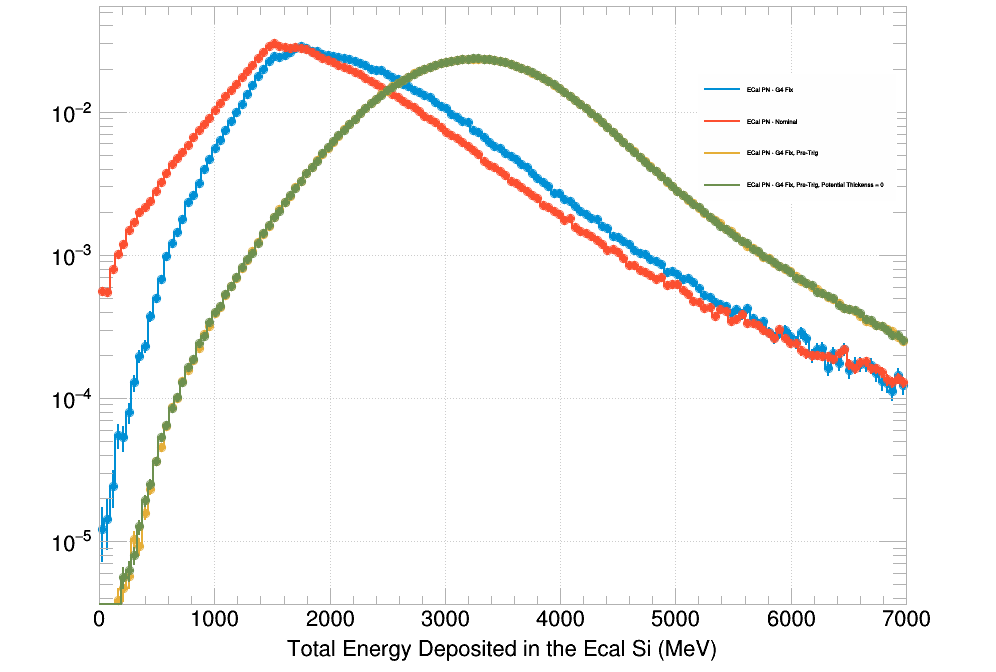

In [33]:
hists = overlay_plot_1d(ecal_ntuples, 'total_ecal_denergy', 150, 0, 7000, [])

leg = r.TLegend(0.7, 0.7, 0.9, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle('Total Energy Deposited in the Ecal Si (MeV)')
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

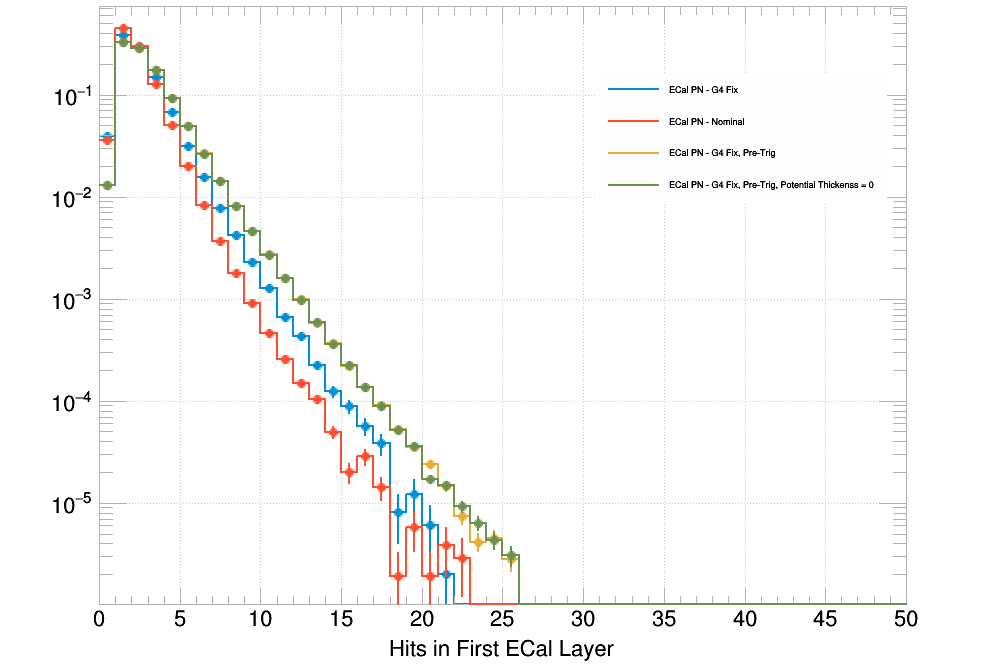

In [34]:
hists = overlay_plot_1d(ecal_ntuples, 'ecal_layer1_hit_count', 50, 0, 50, [])

leg = r.TLegend(0.6, 0.7, 0.89, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("Hits in First ECal Layer")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()

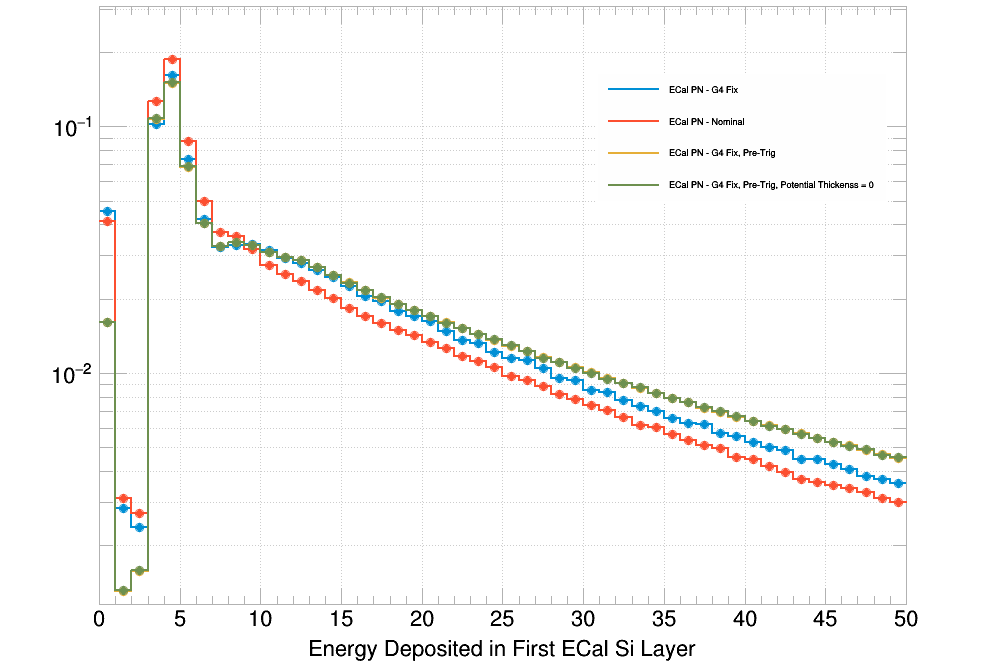

In [35]:
hists = overlay_plot_1d(ecal_ntuples, 'ecal_layer1_energy_sum', 50, 0, 50, [])

leg = r.TLegend(0.6, 0.7, 0.89, 0.89)
ihist = 0
for key, value in hists.iteritems():
    if ihist == 0: hists[key].Draw("HISTE")
    else: hists[key].Draw("HISTE same")
    
    hists[key].GetXaxis().SetTitle("Energy Deposited in First ECal Si Layer")
    leg.AddEntry(hists[key], key, 'l')
    
    ihist += 1
    
leg.Draw()
leg.SetLineColor(0)
leg.SetFillColor(-1)
canvas.SetLogy(1)
canvas.Draw()